# Image Data Augmentation with Keras

In this tutorial we'll take a look at one possible scenario when working with CNN: having to train an image-classification model using very little data. A "few" samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we'll focus on classifying images as dogs or cats in a dataset containing 5,000 pictures of cats and dogs (2,500 cats, 2,500 dogs). We'll use 2000 pictures for training, 1000 for validation, and 2000 for testing.

## Preparation

This section will setup our environment, mount GDrive, and and connect to Kaggle.

Now that we have downloaded and unzziped the data, we will take a small sample and divide it into training/validation/testing sets using the following structure:

```
cats_vs_dogs_small/
...train/
......cat/         
......dog/         
...validation/
......cat/         
......dog/         
...test/
......cat/         
......dog/
```

Notice that we will only take a small sample of the original dataset to simulate training on a smaller dataset (and to accelerate training). We can expect many real world image datasets to follow a similar organization scheme, with separate folders for each class.

In [6]:
# import os, shutil, pathlib

# original_dir = pathlib.Path("train")
# new_base_dir = pathlib.Path("cats_vs_dogs_small")

# def make_subset(subset_name, start_index, end_index):
#     for category in ("cat", "dog"):
#         dir = new_base_dir / subset_name / category
#         os.makedirs(dir)
#         fnames = [f"{category}.{i}.jpg"
#                   for i in range(start_index, end_index)]
#         for fname in fnames:
#             shutil.copyfile(src=original_dir / fname,
#                             dst=dir / fname)

# make_subset("train", start_index=0, end_index=1000)
# make_subset("validation", start_index=1000, end_index=1500)
# make_subset("test", start_index=1500, end_index=2500)

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

## Building the model

We are now ready to build a CNN. We will opt for a "classic" architecture consisting of 3 x 3 convolution layers with ReLu activation functions, interspaced with 2 x 2 max-pooling layers.

Output will consist of a single dense layer of one unit with a sigmoid activation function, since we only have two possible classes (cats vs dogs).

Notice the first two layers of the model. Input allows us to specify sample images' dimensions (180 x 180, with 3 channels). We're also using a rescaling layer to change images' values to 0 - 255 range.

In [8]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([keras.Input(shape=(180, 180, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(1, activation="sigmoid")])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

We will now use the [`image_dataset_from_directory function`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) to easily load our sample images into a ```Dataset```. The function will automatically
* Read the picture files.
* Decode the JPEG content to RGB grids of pixels.
* Convert these into floating-point tensors.
* Assign a label based on parent folder.
* Resize them to a shared size (we'll use 180 × 180).
* Pack them into batches (we'll use batches of 32 images).

The use of a dataset generator is fundamental when working with huge amounts of data, since generally we won't be able to load all of them into memory. A data generator will instead only load the batches into memory on demand.

In [10]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


We are now ready to start training our model. We'll add a callback to save the best model's weights based on the validation loss value.

In [12]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(train_dataset, epochs=11,
                    validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/11
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 494ms/step - accuracy: 0.5180 - loss: 0.8137 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 2/11
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 525ms/step - accuracy: 0.5025 - loss: 0.6923 - val_accuracy: 0.5710 - val_loss: 0.6833
Epoch 3/11
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 579ms/step - accuracy: 0.5168 - loss: 0.6950 - val_accuracy: 0.5070 - val_loss: 0.6829
Epoch 4/11
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 592ms/step - accuracy: 0.5641 - loss: 0.6823 - val_accuracy: 0.5130 - val_loss: 0.8438
Epoch 5/11
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 588ms/step - accuracy: 0.6346 - loss: 0.6383 - val_accuracy: 0.6510 - val_loss: 0.6241
Epoch 6/11
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 620ms/step - accuracy: 0.6882 - loss: 0.5864 - val_accuracy: 0.7040 - val_loss: 0.5890
Epoch 7/11
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 646ms/step - accuracy: 0.7318 - loss: 0.5418 - val_accuracy: 0.6820 - val_loss: 0.5788
Epoch 8/11
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 656ms/step - accuracy: 0.7352 - loss: 0.5168 - val_accu

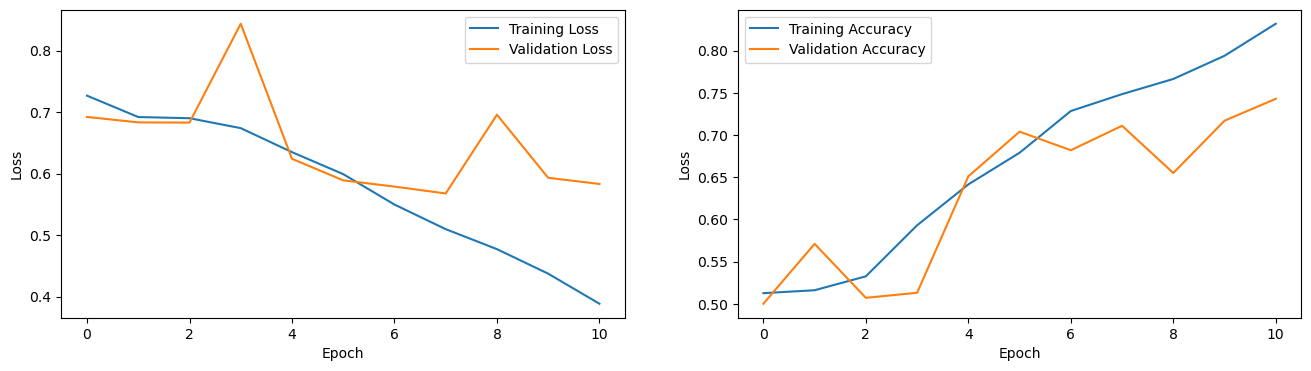

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

After only a few epochs we can readily observe the beggining of overfitting (notice the widening gap between training and validation). This is to be expected due to the (relatively) small amount of training images.

If we test accuracy of the model against the testing set, the results (as expected) are not great.

In [15]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.7210 - loss: 0.5349
Test accuracy: 0.705


We can try fighting overfitting using some of the previously discussed  techniques (like dropout layers or l2 regularization), however another powerful tool at our disposal is data augmentation.

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that, at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data so it can generalize better.

We'll create a data augmentation model that will at random flip the images horizontally, rotate them at most $10\% * 2\pi$ and zoom at most $20\%$. You can find a list of all available [image augmentation layers here](https://keras.io/api/layers/preprocessing_layers/image_augmentation/).

In [16]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)], name='data_augmentation')

2024-10-29 17:21:49.202001: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


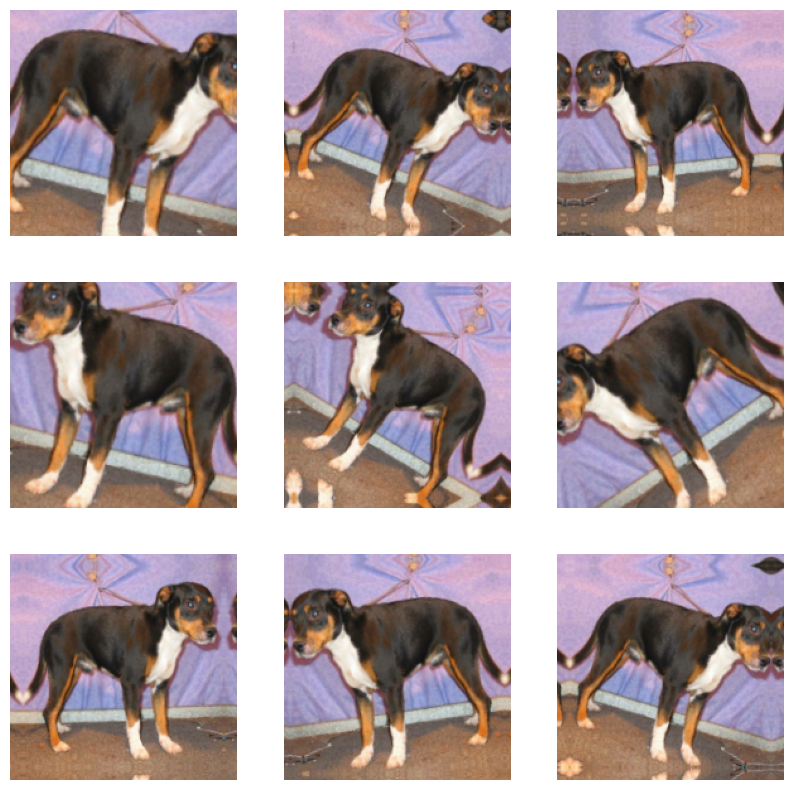

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images) # Keras functional API
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

We can now add these augmentation layers to our previous model and try again. Overfitting should now be significantly lower, so we can train for an extended number of epochs.

In [18]:
model = keras.Sequential([keras.Input(shape=(180, 180, 3)),
                          data_augmentation,
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(1, activation="sigmoid")])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

**Notice** our ```ModelCheckpoint``` callback will, once again, save the best model's weights. This will allow us to rollback to a previous version if we notice overfitting or pick up where we left off in a future session.

In [20]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True, monitor="val_loss")]

history = model.fit(train_dataset, epochs=30,
                    validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 587ms/step - accuracy: 0.5086 - loss: 0.7155 - val_accuracy: 0.5060 - val_loss: 0.6913
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 626ms/step - accuracy: 0.5494 - loss: 0.6925 - val_accuracy: 0.6020 - val_loss: 0.6865
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 642ms/step - accuracy: 0.5419 - loss: 0.6887 - val_accuracy: 0.5310 - val_loss: 0.6846
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 648ms/step - accuracy: 0.6086 - loss: 0.6750 - val_accuracy: 0.6410 - val_loss: 0.6427
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 664ms/step - accuracy: 0.6419 - loss: 0.6362 - val_accuracy: 0.5340 - val_loss: 0.6691
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 655ms/step - accuracy: 0.6486 - loss: 0.6199 - val_accuracy: 0.6430 - val_loss: 0.6042
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 661ms/step - accuracy: 0.6810 - loss: 0.5948 - val_accuracy: 0.6130 - val_loss: 0.6359
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 663ms/step - accuracy: 0.6999 - loss: 0.5728 - val_accu

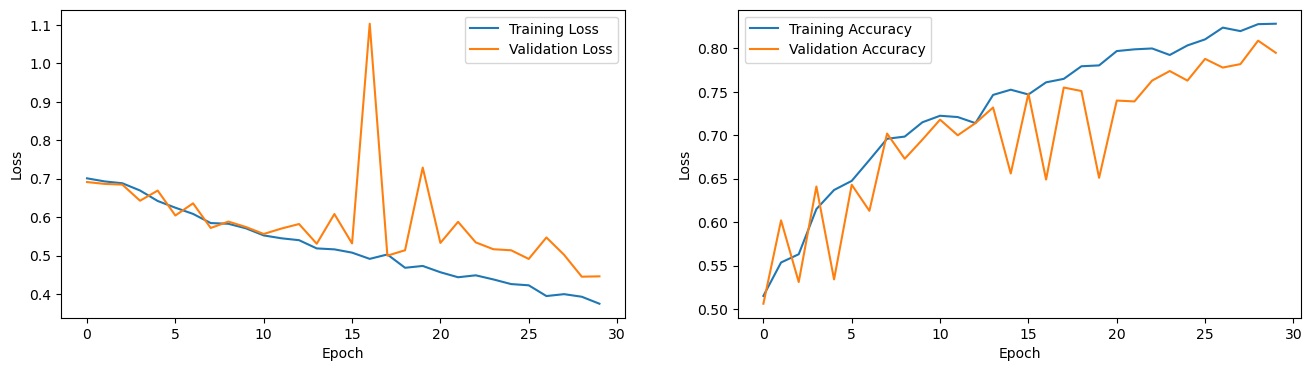

In [21]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and validation scores should now remain closer, meaning we have effectively fought off overfitting. Similarly, test score should now be higher than before.

In [22]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.7894 - loss: 0.4461
Test accuracy: 0.791


## A Note on Data Augmentation with ImageDataGenerator
In the past, Keras `ImageDataGenerator` was the suggested method for generating batches of tensor image data with real-time data augmentation. However, as of TF 2.9.0 `ImageDataGenerator` has been marked as deprecated, so using it in new code is not advisable.

Found 2000 images belonging to 2 classes.


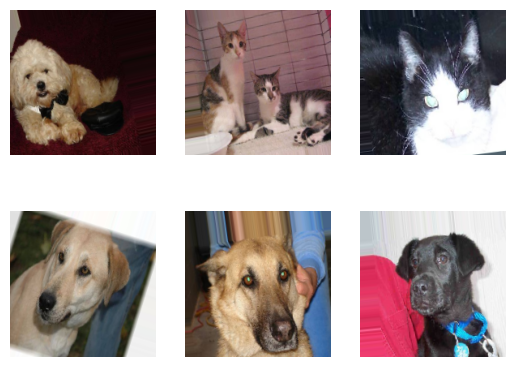

In [23]:
datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(new_base_dir / "train",
                            target_size=(180, 180), batch_size=32)

for X_batch, y_batch in train_generator:
    for i in range(0, 6):
        plt.subplot(2,3,i+1)
        plt.imshow(X_batch[i]/255)
        plt.axis('off')
    break

*Parts of this tutorial have been adapted from [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/) By Aurélien Géron*